In [31]:
#TO RE-RUN
%reset -f

In [43]:
from sklearn import preprocessing
from time import time
import numpy as np
import csv
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline


from sklearn.metrics import pairwise_distances
from IPython.display import display, HTML
from operator import truediv
import pandas as pd
import time
import os

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.3f}'.format
plt.style.use('classic')

%matplotlib inline

import sys
sys.path.insert(1, "../src/")
from TypeFeatImputer import TypeFeatImputer

#### Required domain methods

In [113]:
import sys
sys.path.insert(1, "../src/")
from TypeFeatImputer import TypeFeatImputer
from UnivCombineFilter import UnivCombineFilter
import MLpipeline as MLpipeline
import readmision_methods as rm

In [44]:
typeEncounter = "last" # ['first','last']
typeHypothesis = "early_readmission_vs_none" # ['all_readmisssion_vs_none','early_readmission_vs_none']
typeDataFeatures = "extended_extra_diag_3" # ["reduced","extended','extended_extra','extended_extra_diag_1','extended_extra_diag_3']
    #Extended_Extra_diag_1 -> Extended extra columns with disease in diag_3
    #Extended_Extra_diag_1 -> Extended extra columns with disease in diag_1
    #Extended_Extra -> Extended extra of columns
    #Extended -> Extended columns
    #Reduced -> minimum set of columns 
typeDataExperiment = "all" #["all", "disease"] 
    #all -> No filter disease column
    #disease -> Filter/Remove disease column and keep only rows with diagnosis column == 1    

In [114]:
#Load data
df_all = rm.load_data(typeEncounter, typeDataFeatures)
print "\nSHAPE:"
print df_all.shape

#Filter data by class
df_all = rm.filter_data_by_class(df_all, typeHypothesis)
print "\nSHAPE FILTERED:"
print df_all.shape

print "\nRows by class type:"
print df_all.iloc[:,-1].sort_values().unique(), np.sum(df_all["readmitted"] == 0), np.sum(df_all["readmitted"] == 1)

#Train & Test
X_train, X_test, y_train, y_test = MLpipeline.train_test_partition(df_all)
print "Train:", X_train.shape, "Test:",  X_test.shape


SHAPE:
(67182, 61)

SHAPE FILTERED:
(45779, 61)

Rows by class type:
[0 1] 39785 5994
Train: (32045, 60) Test: (13734, 60)

Hyperparams:
[['fs' 'combine_fs' {'combine_fs__percentile': [5, 10, 20, 30, 40, 50]}]
 ['fs' 'rfe_rf_fs'
  {'rfe_rf_fs__n_features_to_select': [5, 10, 15, 20], 'rfe_rf_fs__step': [0.1]}]
 ['fs' 'lasso_fs' {'lasso_fs__estimator__C': [0.001, 0.01, 0.1, 1]}]
 ['cls' 'knn'
  {'knn__weights': ['uniform', 'distance'], 'knn__n_neighbors': [1, 3, 5, 7, 9, 11]}]
 ['cls' 'logReg'
  {'logReg__class_weight': [None, 'balanced'], 'logReg__C': [1e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 30], 'logReg__penalty': ['l1', 'l2']}]
 ['cls' 'svmRBF'
  {'svmRBF__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5], 'svmRBF__class_weight': [None, 'balanced'], 'svmRBF__C': [0.01, 0.1, 0.5, 1, 5, 10, 30, 50, 100]}]
 ['cls' 'rf'
  {'rf__criterion': ['entropy', 'gini'], 'rf__max_depth': [None, 4, 8, 12], 'rf__n_estimators': [200, 250, 300, 350, 400, 500]}]
 ['cls' 'nn'
  {'

#### Inspect null values

,%_Null,#_Null,#_No_Null
gender,0.00,3,45776


(1, 3)


<function matplotlib.pyplot.show>

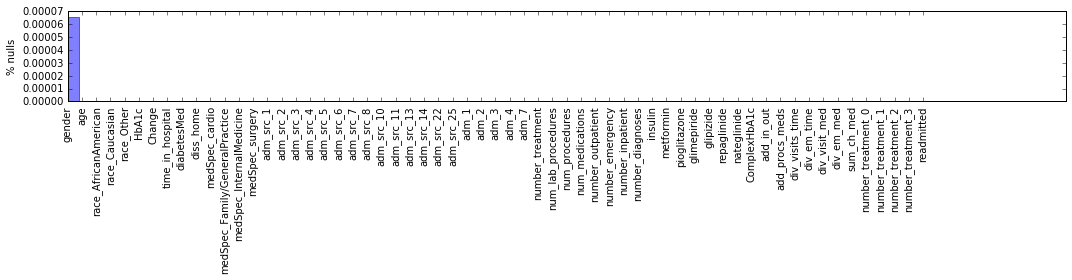

In [115]:
dfNull = np.sum(df_all.isnull()) / float(df_all.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df_all.isnull()),np.sum(df_all.isnull()==False)], axis=1)
dfNullAll.columns= ["%_Null","#_Null","#_No_Null"]

display(dfNullAll[dfNullAll.iloc[:,0].isnull() == False][["%_Null","#_Null","#_No_Null"]])
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape


plt.figure(figsize=(15,4))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:], alpha=0.5)
plt.xticks(range(dfNull.shape[0]),dfNull.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Numeric cols

In [123]:
#Get features by type
catCols, reducedCols = rm.compute_type_features(df_all)
numCols = reducedCols[catCols == 0].values.tolist()  
print len(numCols), numCols

20 ['time_in_hospital', 'number_treatment', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'add_in_out', 'add_procs_meds', 'div_visits_time', 'div_em_time', 'div_visit_med', 'div_em_med', 'sum_ch_med', 'number_treatment_0', 'number_treatment_1', 'number_treatment_2', 'number_treatment_3']


#### Add extra columns

In [124]:
df_all["add_home_no_dmed"] = -1
df_all["add_home_no_dmed"] = np.logical_and((df_all['diss_home']==1), (df_all["diabetesMed"] == 0))
print df_all["add_home_no_dmed"].value_counts()


df_all["prod_lab_med"] = -1
df_all["prod_lab_med"] = df_all["num_lab_procedures"] + df_all["num_medications"]
numCols.extend(["prod_lab_med"])

print len(numCols)

False    38053
True      7726
Name: add_home_no_dmed, dtype: int64
21


#### Find categorical features

In [125]:
#Compute type fields

catCols = []
cols = df_all.columns
reducedCols = df_all.columns[:-1]

for i in range(len(cols)):
    if cols[i] not in numCols:
        catCols.append(1)
    else:
        catCols.append(0)
catCols = np.array(catCols)

print "Cat cols:", np.sum(catCols==1)
print "Num cols:", np.sum(catCols==0)
print len(reducedCols)
print len(cols)

Cat cols: 42
Num cols: 21
62
63


#### Identify categorical features with less 5% values

In [135]:
total = 0
minFreq = df_all.shape[0] * 0.005
todel = []

print "MAX=", df_all.shape[0], "MIN:", minFreq
for c in df_all.columns[catCols == 1]:
    numag = np.argmax(pd.value_counts(df_all[c]))
    ix = [i for i in pd.value_counts(df_all[c]).index if i != numag]
    #print ix
    #print pd.value_counts(df_all[c]).iloc[ix].values
    num = np.sum(pd.value_counts(df_all[c]).iloc[ix].values)
    if num < minFreq:
        total += 1
        todel.append(c)
        print
        print len(df_all[c].unique()), numag, df_all[c].unique().tolist()
        print pd.value_counts(df_all[c]).sort_values(0)

print "total low variance features:", total
print todel

MAX= 45779 MIN: 228.895

2 0 [0L, 1L]
1       57
0    45722
Name: adm_src_3, dtype: int64

2 0 [0L, 1L]
1       10
0    45769
Name: adm_src_8, dtype: int64

2 0 [0L, 1L]
1        5
0    45774
Name: adm_src_10, dtype: int64

2 0 [0L, 1L]
1        1
0    45778
Name: adm_src_11, dtype: int64

2 0 [0L, 1L]
1        1
0    45778
Name: adm_src_13, dtype: int64

2 0 [0L, 1L]
1        2
0    45777
Name: adm_src_14, dtype: int64

2 0 [0L, 1L]
1        4
0    45775
Name: adm_src_22, dtype: int64

2 0 [0L, 1L]
1        2
0    45777
Name: adm_src_25, dtype: int64

2 0 [0L, 1L]
1        7
0    45772
Name: adm_4, dtype: int64

2 0 [0L, 1L]
1       18
0    45761
Name: adm_7, dtype: int64
total low variance features: 10
['adm_src_3', 'adm_src_8', 'adm_src_10', 'adm_src_11', 'adm_src_13', 'adm_src_14', 'adm_src_22', 'adm_src_25', 'adm_4', 'adm_7']


#### Data Exploration

Categorical

In [136]:
from sklearn.feature_selection import chi2

for cond in ["non_all", "non_early"]:
    
    if cond == "non_all":
        dfFilteredAux = df_all.copy()
        classVal = dfFilteredAux["readmitted"]>0
    else:
        dfFilteredAux = df_all[df_all["readmitted"]<=1].copy()
        classVal = dfFilteredAux["readmitted"]>0
        
    catData = []    
    for rv in dfFilteredAux.columns[catCols == 1]:

        cleanIc = dfFilteredAux[rv]

        #Null policy (drop)
        ix = cleanIc.dropna().index

        #Get readmitted
        #valClass = dfFiltered["readmitted"]>0        
        r, p = chi2(cleanIc.dropna().values.astype(int).reshape(-1,1),classVal[ix].astype(int).reshape(-1,1))    

        perc = (pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] == 0][rv])/dfFilteredAux[dfFilteredAux["readmitted"] == 0][rv].count()).round(3).values.tolist()
        perc_1 = (pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] > 0][rv])/dfFilteredAux[dfFilteredAux["readmitted"] > 0][rv].count()).round(3).values.tolist()
        catData.append([str(rv),
                        np.sum(cleanIc.isnull() == False),
                        np.sum(cleanIc.isnull() == True),
                        np.sum(cleanIc.isnull()) / float(len(cleanIc)),
                        pd.value_counts(cleanIc).index.astype(int).tolist(), 
                        pd.value_counts(cleanIc).values.tolist(),
                        str(pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] == 0][rv]).values.tolist()),
                        str(pd.value_counts(dfFilteredAux[dfFilteredAux["readmitted"] > 0][rv]).values.tolist()),
                        str(perc),                        
                        str(perc_1),                    
                        abs(perc_1[0] - perc[0]),
                        round(p,4),
                        "yes" if p<0.05 else "no"
                        ])

    dfCatData = pd.DataFrame(catData, columns=["variable","num","#nulls",u"%nulls","values","frequencies",
                                               "non-readmitted (n)",
                                               "readmitted (n)" if cond == "non_all" else "early_readmitted (n)",
                                               "non-readmitted (%)",
                                               "readmitted (%)" if cond == "non_all" else "early_readmitted (%)",
                                               "diff (%)",
                                               "p-value","sig."])
    print dfCatData[dfCatData["p-value"] < 0.05].shape
    display(HTML(dfCatData[np.logical_and(dfCatData["p-value"] < 0.05, dfCatData["diff (%)"] >= 0.01)].sort_values("diff (%)", ascending=False).to_html(index=False)))

/home/ilmira/.conda/envs/readmision/lib/python2.7/site-packages/ipykernel_launcher.py:22: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(23, 13)


variable,num,#nulls,%nulls,values,frequencies,non-readmitted (n),readmitted (n),non-readmitted (%),readmitted (%),diff (%),p-value,sig.
diss_home,45779,0,0.00,"[1, 0]","[30464, 15315]","[27381, 12404]","[3083, 2911]","[0.688, 0.312]","[0.514, 0.486]",0.17,0.00,yes
add_home_no_dmed,45779,0,0.00,"[0, 1]","[38053, 7726]","[32675, 7110]","[5378, 616]","[0.821, 0.179]","[0.897, 0.103]",0.08,0.00,yes
diabetesMed,45779,0,0.00,"[1, 0]","[34461, 11318]","[29648, 10137]","[4813, 1181]","[0.745, 0.255]","[0.803, 0.197]",0.06,0.00,yes
age,45779,0,0.00,"[7, 6, 5, 8, 4, 3, 9, 2, 1, 0]","[11068, 10248, 8212, 7091, 4646, 1910, 1282, 8...","[9340, 8905, 7370, 5931, 4172, 1733, 1122, 743...","[1728, 1343, 1160, 842, 474, 177, 160, 82, 25, 3]","[0.235, 0.224, 0.185, 0.149, 0.105, 0.044, 0.0...","[0.288, 0.224, 0.194, 0.14, 0.079, 0.03, 0.027...",0.05,0.00,yes
HbA1c,45779,0,0.00,"[0, 3, 1, 2]","[36679, 4260, 2786, 2054]","[32150, 3615, 2322, 1698]","[4529, 645, 464, 356]","[0.808, 0.091, 0.058, 0.043]","[0.756, 0.108, 0.077, 0.059]",0.05,0.00,yes
insulin,45779,0,0.00,"[0, 2, 1, 3]","[22137, 14559, 4705, 4378]","[19503, 12606, 3947, 3729]","[2634, 1953, 758, 649]","[0.49, 0.317, 0.099, 0.094]","[0.439, 0.326, 0.126, 0.108]",0.05,0.00,yes
race_Caucasian,45779,0,0.00,"[1, 0]","[33763, 12016]","[29135, 10650]","[4628, 1366]","[0.732, 0.268]","[0.772, 0.228]",0.04,0.00,yes
Change,45779,0,0.00,"[0, 1]","[25395, 20384]","[22273, 17512]","[3122, 2872]","[0.56, 0.44]","[0.521, 0.479]",0.04,0.00,yes
adm_src_7,45779,0,0.00,"[1, 0]","[23748, 22031]","[20443, 19342]","[3305, 2689]","[0.514, 0.486]","[0.551, 0.449]",0.04,0.00,yes
adm_3,45779,0,0.00,"[0, 1]","[36296, 9483]","[31370, 8415]","[4926, 1068]","[0.788, 0.212]","[0.822, 0.178]",0.03,0.00,yes


(23, 13)


variable,num,#nulls,%nulls,values,frequencies,non-readmitted (n),early_readmitted (n),non-readmitted (%),early_readmitted (%),diff (%),p-value,sig.
diss_home,45779,0,0.00,"[1, 0]","[30464, 15315]","[27381, 12404]","[3083, 2911]","[0.688, 0.312]","[0.514, 0.486]",0.17,0.00,yes
add_home_no_dmed,45779,0,0.00,"[0, 1]","[38053, 7726]","[32675, 7110]","[5378, 616]","[0.821, 0.179]","[0.897, 0.103]",0.08,0.00,yes
diabetesMed,45779,0,0.00,"[1, 0]","[34461, 11318]","[29648, 10137]","[4813, 1181]","[0.745, 0.255]","[0.803, 0.197]",0.06,0.00,yes
age,45779,0,0.00,"[7, 6, 5, 8, 4, 3, 9, 2, 1, 0]","[11068, 10248, 8212, 7091, 4646, 1910, 1282, 8...","[9340, 8905, 7370, 5931, 4172, 1733, 1122, 743...","[1728, 1343, 1160, 842, 474, 177, 160, 82, 25, 3]","[0.235, 0.224, 0.185, 0.149, 0.105, 0.044, 0.0...","[0.288, 0.224, 0.194, 0.14, 0.079, 0.03, 0.027...",0.05,0.00,yes
HbA1c,45779,0,0.00,"[0, 3, 1, 2]","[36679, 4260, 2786, 2054]","[32150, 3615, 2322, 1698]","[4529, 645, 464, 356]","[0.808, 0.091, 0.058, 0.043]","[0.756, 0.108, 0.077, 0.059]",0.05,0.00,yes
insulin,45779,0,0.00,"[0, 2, 1, 3]","[22137, 14559, 4705, 4378]","[19503, 12606, 3947, 3729]","[2634, 1953, 758, 649]","[0.49, 0.317, 0.099, 0.094]","[0.439, 0.326, 0.126, 0.108]",0.05,0.00,yes
race_Caucasian,45779,0,0.00,"[1, 0]","[33763, 12016]","[29135, 10650]","[4628, 1366]","[0.732, 0.268]","[0.772, 0.228]",0.04,0.00,yes
Change,45779,0,0.00,"[0, 1]","[25395, 20384]","[22273, 17512]","[3122, 2872]","[0.56, 0.44]","[0.521, 0.479]",0.04,0.00,yes
adm_src_7,45779,0,0.00,"[1, 0]","[23748, 22031]","[20443, 19342]","[3305, 2689]","[0.514, 0.486]","[0.551, 0.449]",0.04,0.00,yes
adm_3,45779,0,0.00,"[0, 1]","[36296, 9483]","[31370, 8415]","[4926, 1068]","[0.788, 0.212]","[0.822, 0.178]",0.03,0.00,yes


Numerical

In [137]:
from scipy import stats


for cond in ["non_all", "non_early"]:
    
    if cond == "non_all":
        dfFilteredAux = df_all.copy()
        classVal = dfFilteredAux["readmitted"]>0
    else:
        dfFilteredAux = df_all[df_all["readmitted"]<=1].copy()
        classVal = dfFilteredAux["readmitted"]>0


    numData = dfFilteredAux[dfFilteredAux.columns[catCols == 0]].describe().T[["count","mean","std"]].copy()
    numData.insert(0,"variable",numData.index.values)
    numData.insert(1,"num", dfFilteredAux.shape[0] - numData["count"].isnull().astype(int))
    numData.insert(2,"#nulls",  numData["count"].isnull().astype(int))
    numData.insert(3,"%nulls", numData["#nulls"] / dfFilteredAux.shape[0])


    numData_non_comp = dfFilteredAux[dfFilteredAux["readmitted"] == 0][dfFilteredAux.columns[catCols == 0]].describe().T[["mean","std"]]
    numData_comp = dfFilteredAux[dfFilteredAux["readmitted"] > 0][dfFilteredAux.columns[catCols == 0]].describe().T[["mean","std"]]


    numData["mean"] = numData["mean"].round(2).astype(str).str.cat(numData["std"].round(2).astype(str), sep="+/-")
    numData["non-readmitted"] = numData_non_comp["mean"].round(3).astype(str).str.cat(numData_non_comp["std"].round(2).astype(str), sep="+/-")    
    numData["readmitted" if cond == "non_all" else "early_readmitted"] = numData_comp["mean"].round(3).astype(str).str.cat(numData_comp["std"].round(2).astype(str), sep="+/-")
    
    diffRange = numData_non_comp["mean"].max() - numData_non_comp["mean"].min()
    diffRange1 = numData_comp["mean"].max() - numData_comp["mean"].min()
    numData["diff"] = abs(
        ((numData_non_comp["mean"] - numData_non_comp["mean"].min())/float(diffRange)) -
        ((numData_comp["mean"] - numData_comp["mean"].min())/float(diffRange1)))
    pvals = []

    for v in numData["variable"].values:
        #pvals.append(stats.mannwhitneyu(dfFiltered[v].values.astype(float).reshape(-1,1), 
        #             classVal.astype(int).reshape(-1,1),alternative='two-sided')[1])    
        pvals.append(stats.mannwhitneyu(
            dfFilteredAux[v].loc[classVal == False].values.astype(float).reshape(-1,1), 
            dfFilteredAux[v].loc[classVal == True].values.astype(float).reshape(-1,1)
            )[1])

    numData["p-value"] = pvals
    numData["sig"] = numData["p-value"] < 0.05

    numData = numData[["variable","num","#nulls","%nulls",
                       "mean","non-readmitted",
                       "readmitted" if cond == "non_all" else "early_readmitted",
                       "diff","p-value","sig"]]

    display(HTML(numData.sort_values("diff", ascending=False).to_html(index=False)))

variable,num,#nulls,%nulls,mean,non-readmitted,readmitted,diff,p-value,sig
number_treatment_0,45779,0,0.00,21.82+/-0.95,21.826+/-0.96,21.766+/-0.91,0.02,0.00,True
time_in_hospital,45779,0,0.00,4.19+/-2.91,4.105+/-2.88,4.767+/-3.04,0.01,0.00,True
add_in_out,45779,0,0.00,0.39+/-1.12,0.34+/-1.04,0.702+/-1.51,0.01,0.00,True
number_inpatient,45779,0,0.00,0.14+/-0.55,0.108+/-0.43,0.383+/-1.0,0.00,0.00,True
num_medications,45779,0,0.00,15.53+/-8.42,15.371+/-8.44,16.607+/-8.25,0.00,0.00,True
num_procedures,45779,0,0.00,1.44+/-1.75,1.441+/-1.75,1.4+/-1.72,0.00,0.09,False
prod_lab_med,45779,0,0.00,58.0+/-23.57,57.468+/-23.58,61.568+/-23.23,0.00,0.00,True
div_visits_time,45779,0,0.00,0.14+/-0.55,0.131+/-0.52,0.234+/-0.69,0.00,0.00,True
number_emergency,45779,0,0.00,0.08+/-0.45,0.074+/-0.43,0.156+/-0.59,0.00,0.00,True
number_outpatient,45779,0,0.00,0.24+/-0.95,0.231+/-0.93,0.318+/-1.06,0.00,0.00,True


variable,num,#nulls,%nulls,mean,non-readmitted,early_readmitted,diff,p-value,sig
number_treatment_0,45779,0,0.00,21.82+/-0.95,21.826+/-0.96,21.766+/-0.91,0.02,0.00,True
time_in_hospital,45779,0,0.00,4.19+/-2.91,4.105+/-2.88,4.767+/-3.04,0.01,0.00,True
add_in_out,45779,0,0.00,0.39+/-1.12,0.34+/-1.04,0.702+/-1.51,0.01,0.00,True
number_inpatient,45779,0,0.00,0.14+/-0.55,0.108+/-0.43,0.383+/-1.0,0.00,0.00,True
num_medications,45779,0,0.00,15.53+/-8.42,15.371+/-8.44,16.607+/-8.25,0.00,0.00,True
num_procedures,45779,0,0.00,1.44+/-1.75,1.441+/-1.75,1.4+/-1.72,0.00,0.09,False
prod_lab_med,45779,0,0.00,58.0+/-23.57,57.468+/-23.58,61.568+/-23.23,0.00,0.00,True
div_visits_time,45779,0,0.00,0.14+/-0.55,0.131+/-0.52,0.234+/-0.69,0.00,0.00,True
number_emergency,45779,0,0.00,0.08+/-0.45,0.074+/-0.43,0.156+/-0.59,0.00,0.00,True
number_outpatient,45779,0,0.00,0.24+/-0.95,0.231+/-0.93,0.318+/-1.06,0.00,0.00,True


#### Normality test

In [139]:
arrNorm = []
for i,rv in enumerate(df_all.columns[:-1]):

    #Compute data
    cleanIc = df_all.iloc[:,i]
    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if catCols[i] == 1 else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

display(HTML(dfNorm[dfNorm["categoric"] == "no"][["variable","f_val","p_value","norm"]].to_html(index=False)))

(62, 5)
Normal features: 1
Normal numerical features: 0
Normal categorical features: 1
No Normal features: 61
No Normal numerical features: 20
No Normal categorical features: 41


variable,f_val,p_value,norm
time_in_hospital,8170.4184,0.0,no
number_treatment,3588.8015,0.0,no
num_lab_procedures,564.3426,0.0,no
num_procedures,7622.9087,0.0,no
num_medications,13660.5709,0.0,no
number_outpatient,68733.1965,0.0,no
number_emergency,107301.739,0.0,no
number_inpatient,55540.3053,0.0,no
number_diagnoses,3432.2807,0.0,no
add_in_out,57893.8163,0.0,no


#### Distributions: Numeric features

time_in_hospital
Unique values: 14
p-value: 0.0
Normal: False
Mean: 4.19196574849 std: 2.90601825756
Min: 1 Max: 14


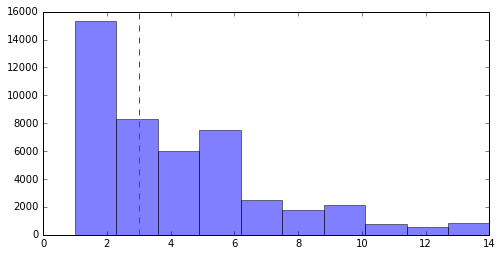

number_treatment
Unique values: 13
p-value: 0.0
Normal: False
Mean: 2.37241966841 std: 1.98917765401
Min: 0 Max: 12


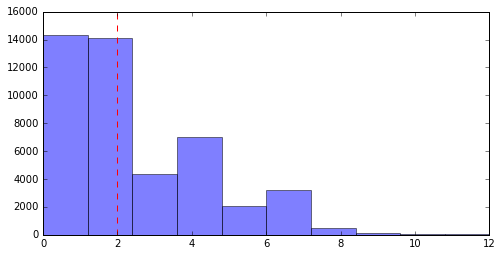

num_lab_procedures
Unique values: 115
p-value: 2.84810637852e-123
Normal: False
Mean: 42.4719849713 std: 19.9453932548
Min: 1 Max: 132


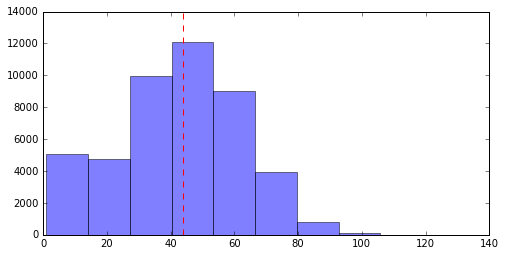

num_procedures
Unique values: 7
p-value: 0.0
Normal: False
Mean: 1.43561458311 std: 1.74818154364
Min: 0 Max: 6


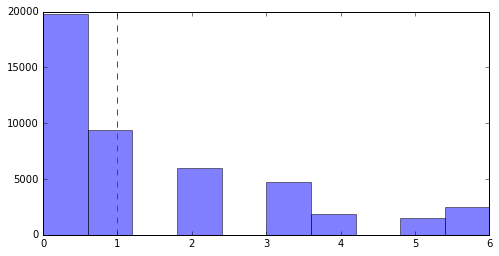

num_medications
Unique values: 75
p-value: 0.0
Normal: False
Mean: 15.5324930645 std: 8.42410853908
Min: 1 Max: 81


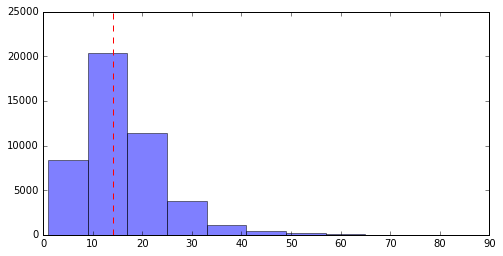

number_outpatient
Unique values: 26
p-value: 0.0
Normal: False
Mean: 0.242622163001 std: 0.94772835279
Min: 0 Max: 36


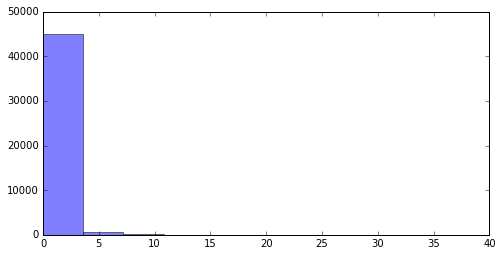

number_emergency
Unique values: 14
p-value: 0.0
Normal: False
Mean: 0.0848860831386 std: 0.453767746641
Min: 0 Max: 37


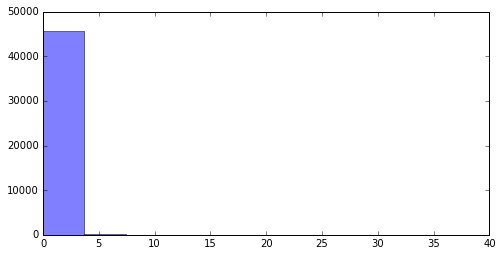

number_inpatient
Unique values: 13
p-value: 0.0
Normal: False
Mean: 0.144476725136 std: 0.546459463988
Min: 0 Max: 12


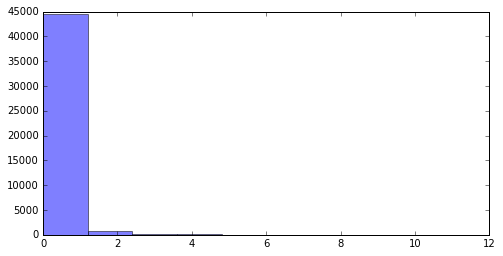

number_diagnoses
Unique values: 16
p-value: 0.0
Normal: False
Mean: 7.14775333668 std: 2.03523322532
Min: 1 Max: 16


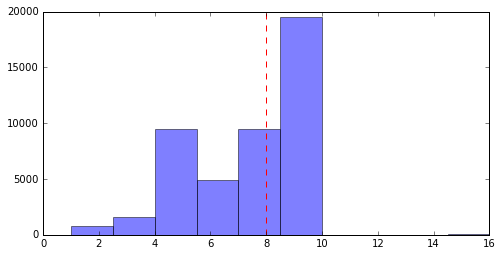

add_in_out
Unique values: 27
p-value: 0.0
Normal: False
Mean: 0.387098888136 std: 1.12192961749
Min: 0 Max: 36


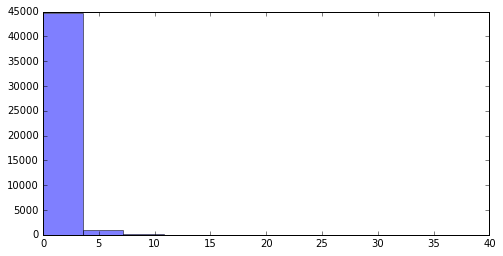

add_procs_meds
Unique values: 159
p-value: 1.52764081471e-54
Normal: False
Mean: 59.4400926189 std: 23.9440733683
Min: 2.0 Max: 170.0


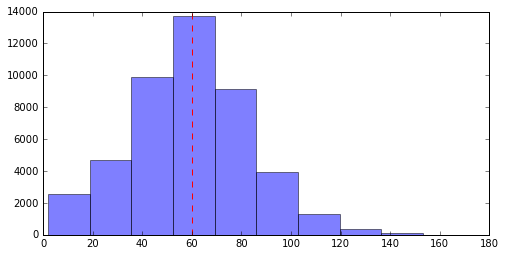

div_visits_time
Unique values: 109
p-value: 0.0
Normal: False
Mean: 0.144610493739 std: 0.546310167179
Min: 0.0 Max: 36.0


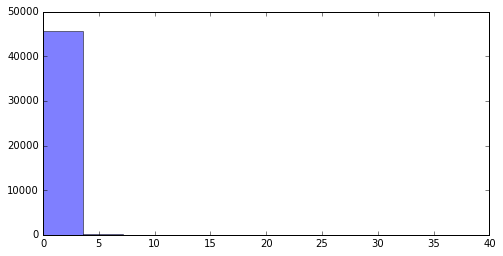

div_em_time
Unique values: 55
p-value: 0.0
Normal: False
Mean: 0.0332476977746 std: 0.259220147379
Min: 0.0 Max: 37.0


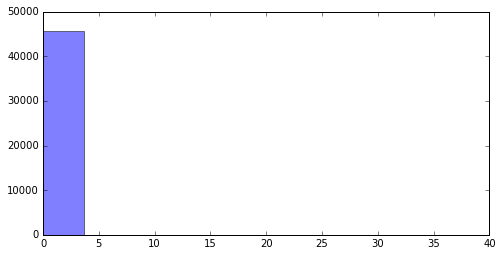

div_visit_med
Unique values: 261
p-value: 0.0
Normal: False
Mean: 0.0299817688659 std: 0.103229868718
Min: 0.0 Max: 4.0


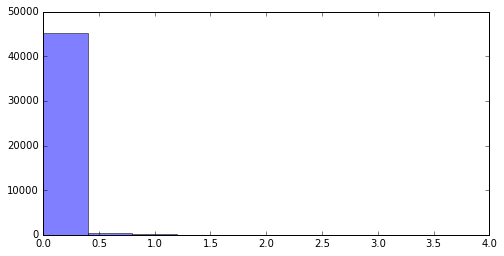

div_em_med
Unique values: 125
p-value: 0.0
Normal: False
Mean: 0.00725375390225 std: 0.0480346094016
Min: 0.0 Max: 4.625


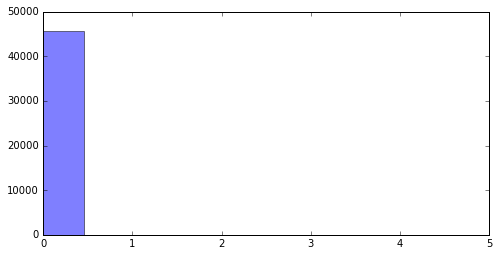

sum_ch_med
Unique values: 3
p-value: 1.02634383313e-218
Normal: False
Mean: 1.19803840189 std: 0.808258448611
Min: 0 Max: 2


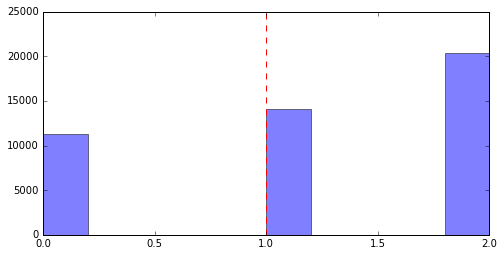

number_treatment_0
Unique values: 7
p-value: 0.0
Normal: False
Mean: 21.8184320322 std: 0.95065807841
Min: 17 Max: 23


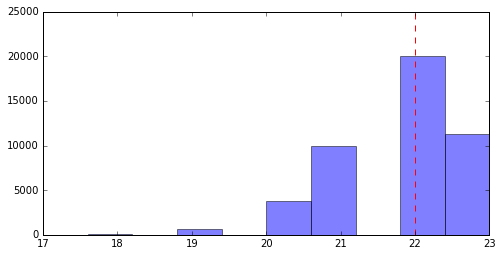

number_treatment_1
Unique values: 4
p-value: 0.0
Normal: False
Mean: 0.123550099391 std: 0.337328000216
Min: 0 Max: 3


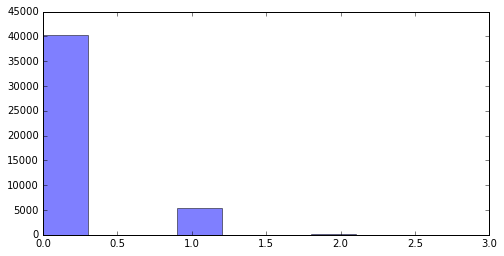

number_treatment_2
Unique values: 7
p-value: 0.0
Normal: False
Mean: 0.925184036349 std: 0.917258397766
Min: 0 Max: 6


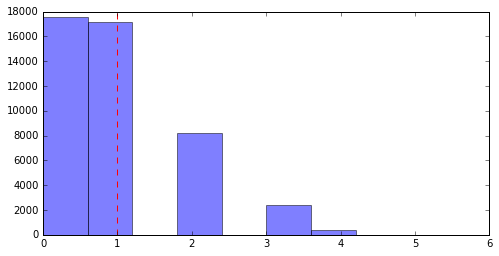

number_treatment_3
Unique values: 4
p-value: 0.0
Normal: False
Mean: 0.132833832106 std: 0.358305494863
Min: 0 Max: 3


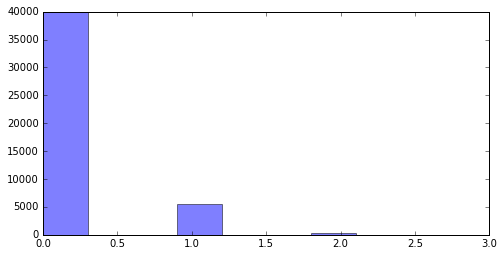

In [141]:
from scipy.stats import boxcox

for i,rv in enumerate(df_all.columns[:-1]):

    #Compute data
    cleanIc = df_all.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        print "Min:", np.min(cleanIc), "Max:", np.max(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10, alpha=0.5)
        plt.axvline(np.median(cleanIc), c="r", ls="--")
        plt.show()        

gender
(2,)
1.000    38023
0.000    33492
Name: gender, dtype: int64


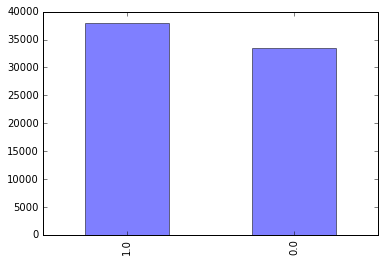

age
(10,)
7    18162
6    15908
5    12349
8    11864
4     6756
3     2650
9     2040
2     1111
1      525
0      153
Name: age, dtype: int64


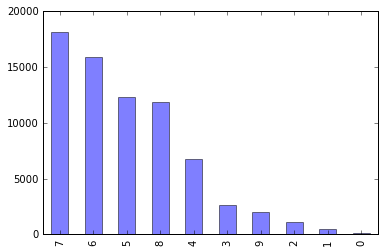

metformin
(4,)
0    56944
2    13347
3      798
1      429
Name: metformin, dtype: int64


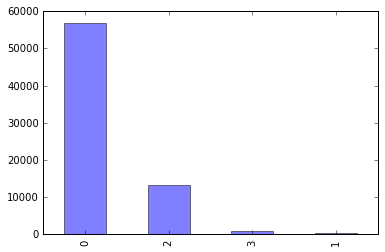

repaglinide
(4,)
0    70548
2      857
3       78
1       35
Name: repaglinide, dtype: int64


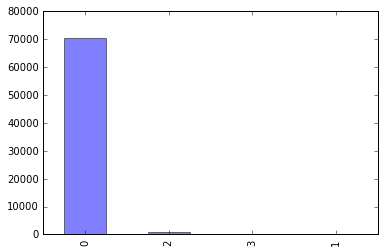

glimepiride
(4,)
0    67833
2     3306
3      242
1      137
Name: glimepiride, dtype: int64


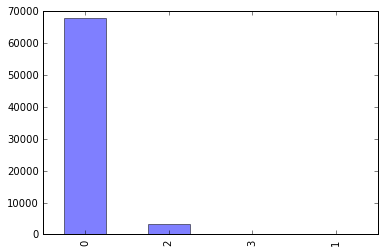

glipizide
(4,)
0    62711
2     7905
3      552
1      350
Name: glipizide, dtype: int64


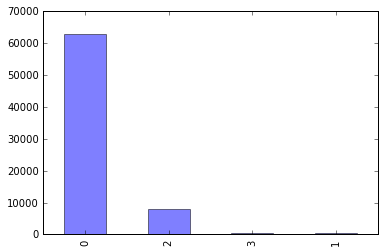

glyburide
(4,)
0    63989
2     6555
3      586
1      388
Name: glyburide, dtype: int64


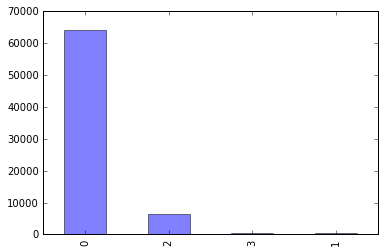

pioglitazone
(4,)
0    66308
2     4957
3      167
1       86
Name: pioglitazone, dtype: int64


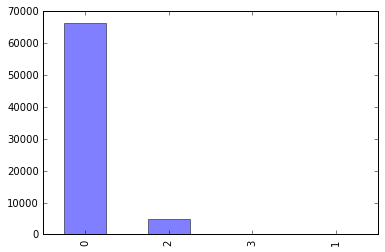

rosiglitazone
(4,)
0    67118
2     4197
3      133
1       70
Name: rosiglitazone, dtype: int64


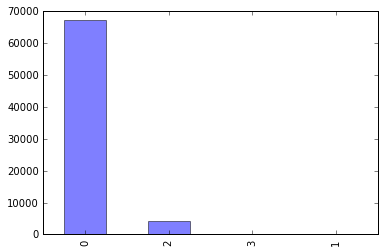

insulin
(4,)
0    34335
2    22247
1     7729
3     7207
Name: insulin, dtype: int64


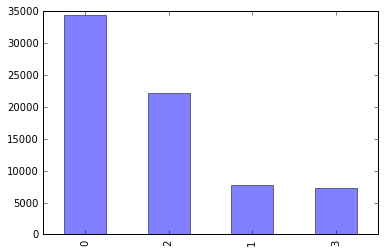

diabetesMed
(2,)
1    54196
0    17322
Name: diabetesMed, dtype: int64


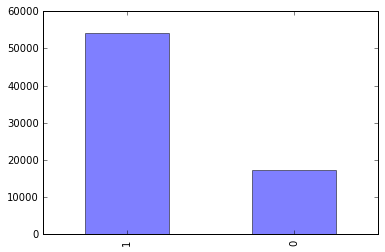

race_AfricanAmerican
(2,)
0    58602
1    12916
Name: race_AfricanAmerican, dtype: int64


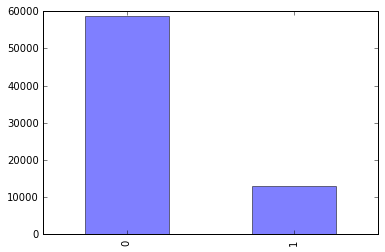

race_Asian
(2,)
0    71006
1      512
Name: race_Asian, dtype: int64


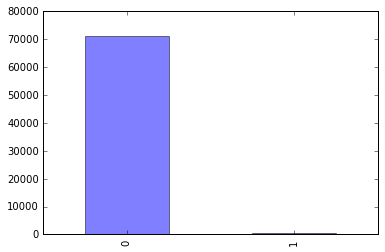

race_Caucasian
(2,)
1    53556
0    17962
Name: race_Caucasian, dtype: int64


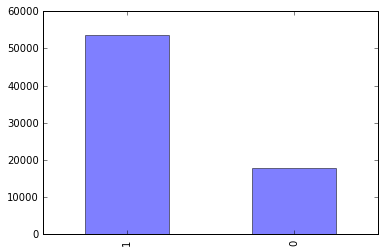

race_Hispanic
(2,)
0    70004
1     1514
Name: race_Hispanic, dtype: int64


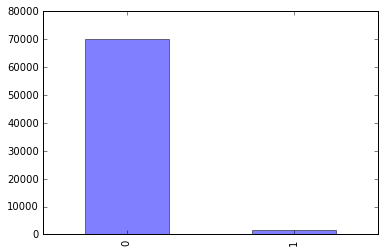

race_Other
(2,)
0    70348
1     1170
Name: race_Other, dtype: int64


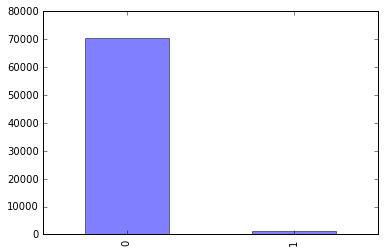

race_nan
(2,)
0    69668
1     1850
Name: race_nan, dtype: int64


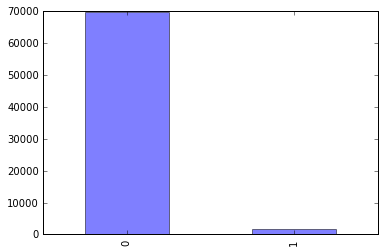

In [195]:
#Categorical
for i,rv in enumerate(dfFiltered.columns[:-1]):

    #Compute data
    cleanIc = dfFiltered.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":
                
        print rv
        print pd.value_counts(cleanIc).shape
        print pd.value_counts(cleanIc)
        pd.value_counts(cleanIc).plot(kind="bar", alpha=0.5)
        plt.show()